In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import gradio as gr

# Set global policy to use float32
tf.keras.mixed_precision.set_global_policy('float32')

# Function to load and process image
def load_and_process_image(image, target_size=(512, 512)):  # Increased resolution
    img = image.resize(target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return tf.convert_to_tensor(img, dtype=tf.float32)  # Ensure the image tensor is float32

# Deprocess the image
def deprocess(x):
    x = x.reshape((512, 512, 3))  # Adjusted for larger image
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Load pre-trained VGG19
def load_vgg_model():
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    return vgg

# Fetch outputs for selected layers
def get_model_outputs(model, layers):
    outputs = [model.get_layer(name).output for name in layers]
    return tf.keras.Model([model.input], outputs)

# Training loop
def style_transfer(content_image, style_image, iterations=500, content_weight=1e4, style_weight=1e-2):
    content_image = load_and_process_image(content_image)
    style_image = load_and_process_image(style_image)
    generated_image = tf.Variable(content_image, dtype=tf.float32)

    vgg = load_vgg_model()

    content_layer = ['block5_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_model = get_model_outputs(vgg, content_layer)
    style_model = get_model_outputs(vgg, style_layers)

    content_features = content_model(content_image)
    style_features = style_model(style_image)

    optimizer = tf.optimizers.Adam(learning_rate=5.0)
    for i in range(iterations):
        with tf.GradientTape() as tape:
            generated_content_features = content_model(generated_image)
            generated_style_features = style_model(generated_image)

            J_content = tf.reduce_mean(tf.square(content_features[0] - generated_content_features[0]))
            J_style = sum([tf.reduce_mean(tf.square(gram_matrix(style_feat) - gram_matrix(gen_feat)))
                           for style_feat, gen_feat in zip(style_features, generated_style_features)])

            total_loss = content_weight * J_content + style_weight * J_style

        gradients = tape.gradient(total_loss, generated_image)
        optimizer.apply_gradients([(gradients, generated_image)])

    return Image.fromarray(deprocess(generated_image.numpy()[0]))

# Gram matrix helper function
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.cast(tf.shape(a)[0], tf.float32)
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / n

# Gradio Interface
def run_style_transfer(content_img, style_img):
    output_image = style_transfer(content_img, style_img)
    return output_image

interface = gr.Interface(
    fn=run_style_transfer,
    inputs=[
        gr.Image(label="Content Image", type="pil"),
        gr.Image(label="Style Image", type="pil")
    ],
    outputs=gr.Image(label="Stylized Image")
)

# Launch the app
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e90e3824d6e7f9c848.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

# Set global policy to use float32
tf.keras.mixed_precision.set_global_policy('float32')

# Function to load and process image
def load_and_process_image(image_url, target_size=(512, 512)):  # Increased resolution
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).resize(target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return tf.convert_to_tensor(img, dtype=tf.float32)  # Ensure the image tensor is float32

# Deprocess the image
def deprocess(x):
    x = x.reshape((512, 512, 3))  # Adjusted for larger image
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Display image
def display_image(image):
    img = deprocess(image)
    plt.grid(False)
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])

# Content cost
def content_cost(content_output, generated_output):
    return tf.reduce_mean(tf.square(content_output - generated_output))

# Style cost
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.cast(tf.shape(a)[0], tf.float32)  # Ensure n is a float tensor
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / n  # No need for tf.cast here

def style_cost(style_output, generated_output):
    S = gram_matrix(style_output)
    G = gram_matrix(generated_output)
    return tf.reduce_mean(tf.square(S - G))

# Load pre-trained VGG19
def load_vgg_model():
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    return vgg

# Fetch outputs for selected layers
def get_model_outputs(model, layers):
    outputs = [model.get_layer(name).output for name in layers]
    return tf.keras.Model([model.input], outputs)

# Training loop
def style_transfer(content_url, style_url, iterations=1000, content_weight=1e4, style_weight=1e-2):  # Increased iterations
    content_image = load_and_process_image(content_url)
    style_image = load_and_process_image(style_url)
    generated_image = tf.Variable(content_image, dtype=tf.float32)  # Keep this as float32

    vgg = load_vgg_model()

    content_layer = ['block5_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_model = get_model_outputs(vgg, content_layer)
    style_model = get_model_outputs(vgg, style_layers)

    content_features = content_model(content_image)
    style_features = style_model(style_image)

    optimizer = tf.optimizers.Adam(learning_rate=5.0)
    for i in range(iterations):
        with tf.GradientTape() as tape:
            generated_content_features = content_model(generated_image)
            generated_style_features = style_model(generated_image)

            # Ensure the features are float32 during loss computation
            J_content = content_cost(tf.cast(content_features[0], tf.float32), generated_content_features[0])
            J_style = sum([style_cost(tf.cast(style_feat, tf.float32), tf.cast(gen_feat, tf.float32))
                           for style_feat, gen_feat in zip(style_features, generated_style_features)])

            total_loss = content_weight * J_content + style_weight * J_style

        gradients = tape.gradient(total_loss, generated_image)
        optimizer.apply_gradients([(gradients, generated_image)])

        if i % 100 == 0:
            print(f"Iteration {i}: Loss: {total_loss.numpy()}")
            display_image(generated_image.numpy())
            plt.show()  # Display after every 100 iterations

    return generated_image

# Example usage
content_image_url = 'https://cdn.mos.cms.futurecdn.net/ntFmJUZ8tw3ULD3tkBaAtf.jpg'
style_image_url = 'https://i.etsystatic.com/25338275/r/il/9b61ed/4762707601/il_570xN.4762707601_dkfd.jpg'

output_image = style_transfer(content_image_url, style_image_url)
plt.imshow(deprocess(output_image.numpy()[0]))
plt.show()


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7cdda85c17b0>

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
import numpy as np
import os

# Set up the VGG model for content and style layers
def load_vgg_model():
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    return vgg

def get_model_outputs(model, layers):
    outputs = [model.get_layer(name).output for name in layers]
    return tf.keras.Model([model.input], outputs)

# Function to test if a path is writable by saving a test file
def test_write_path(save_path):
    test_file_path = os.path.join(os.path.dirname(save_path), "test_file.txt")
    try:
        with open(test_file_path, "w") as f:
            f.write("Test")
        os.remove(test_file_path)  # Clean up test file after testing
        print(f"Path {save_path} is writable.")
    except Exception as e:
        print(f"Error: Cannot write to the path {save_path}. Check permissions or path validity.")
        print(f"Exception: {e}")

# Save the style transfer model as a new model
def create_style_transfer_model(save_path=r"C:\Users\chari\OneDrive\Documents\style_transfer_model.h5", content_weight=1e4, style_weight=1e-2):
    # Test if the save path is writable
    test_write_path(save_path)

    vgg = load_vgg_model()

    # Specify the layers for content and style extraction
    content_layer = ['block5_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

    # Extract model outputs for the specified layers
    content_model = get_model_outputs(vgg, content_layer)
    style_model = get_model_outputs(vgg, style_layers)

    # Create an input layer
    input_image = tf.keras.Input(shape=(512, 512, 3), dtype=tf.float32)

    # Pass input image through the content and style models
    content_features = content_model(input_image)
    style_features = style_model(input_image)

    # Create and save the model
    style_transfer_model = tf.keras.Model(inputs=[input_image], outputs=[content_features, style_features])
    try:
        style_transfer_model.save(save_path)
        print(f"Model saved successfully at {save_path}")
    except Exception as e:
        print(f"Failed to save at {save_path}. Trying backup path.")
        backup_path = r"C:\temp\style_transfer_model.h5"
        os.makedirs(r"C:\temp", exist_ok=True)  # Ensure backup directory exists
        style_transfer_model.save(backup_path)
        print(f"Model saved at backup path: {backup_path}")

# Call the function to create and save the model
create_style_transfer_model()


Path C:\Users\chari\OneDrive\Documents\style_transfer_model.h5 is writable.


Model saved successfully at C:\Users\chari\OneDrive\Documents\style_transfer_model.h5


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

# Set global policy to use float32
tf.keras.mixed_precision.set_global_policy('float32')

# Function to load and process image
def load_and_process_image(image_url, target_size=(512, 512)):  # Increased resolution
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).resize(target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return tf.convert_to_tensor(img, dtype=tf.float32)  # Ensure the image tensor is float32

# Deprocess the image
def deprocess(x):
    x = x.reshape((512, 512, 3))  # Adjusted for larger image
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Save the image to a file
def save_image(image, filename):
    img = deprocess(image.numpy()[0])
    im = Image.fromarray(img)
    im.save(filename)

# Content cost
def content_cost(content_output, generated_output):
    return tf.reduce_mean(tf.square(content_output - generated_output))

# Style cost
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.cast(tf.shape(a)[0], tf.float32)  # Ensure n is a float tensor
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / n  # No need for tf.cast here

def style_cost(style_output, generated_output):
    S = gram_matrix(style_output)
    G = gram_matrix(generated_output)
    return tf.reduce_mean(tf.square(S - G))

# Load pre-trained VGG19
def load_vgg_model():
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    return vgg

# Fetch outputs for selected layers
def get_model_outputs(model, layers):
    outputs = [model.get_layer(name).output for name in layers]
    return tf.keras.Model([model.input], outputs)

# Training loop
def style_transfer(content_url, style_url, iterations=1000, content_weight=1e4, style_weight=1e-2):  # Increased iterations
    content_image = load_and_process_image(content_url)
    style_image = load_and_process_image(style_url)
    generated_image = tf.Variable(content_image, dtype=tf.float32)  # Keep this as float32

    vgg = load_vgg_model()

    content_layer = ['block5_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_model = get_model_outputs(vgg, content_layer)
    style_model = get_model_outputs(vgg, style_layers)

    content_features = content_model(content_image)
    style_features = style_model(style_image)

    optimizer = tf.optimizers.Adam(learning_rate=5.0)
    for i in range(iterations):
        with tf.GradientTape() as tape:
            generated_content_features = content_model(generated_image)
            generated_style_features = style_model(generated_image)

            # Ensure the features are float32 during loss computation
            J_content = content_cost(tf.cast(content_features[0], tf.float32), generated_content_features[0])
            J_style = sum([style_cost(tf.cast(style_feat, tf.float32), tf.cast(gen_feat, tf.float32))
                           for style_feat, gen_feat in zip(style_features, generated_style_features)])

            total_loss = content_weight * J_content + style_weight * J_style

        gradients = tape.gradient(total_loss, generated_image)
        optimizer.apply_gradients([(gradients, generated_image)])

        if i % 100 == 0:
            print(f"Iteration {i}: Loss: {total_loss.numpy()}")
            # Removed the display of the generated image

    # Save the final output image
    save_image(generated_image, 'output_image.png')

# Example usage
content_image_url = ''
style_image_url = ''

style_transfer(content_image_url, style_image_url)

# Display the final output image
final_output_image = Image.open('output_image.png')
plt.imshow(final_output_image)
plt.axis('off')  # Hide axes
plt.show()


MissingSchema: Invalid URL '': No scheme supplied. Perhaps you meant https://?

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Iteration 0: Loss: 1055329856.0


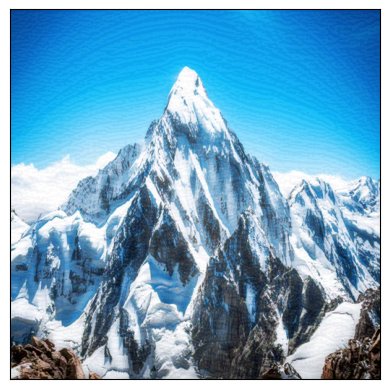

Iteration 100: Loss: 10780812.0


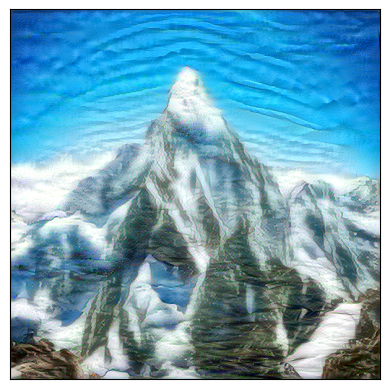

Iteration 200: Loss: 8048409.0


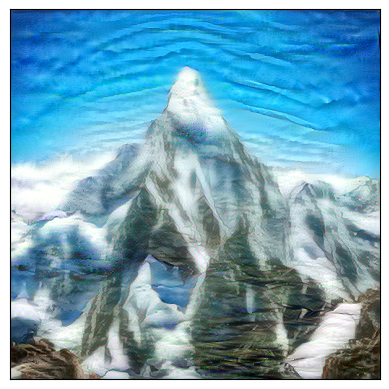

Iteration 300: Loss: 7222577.0


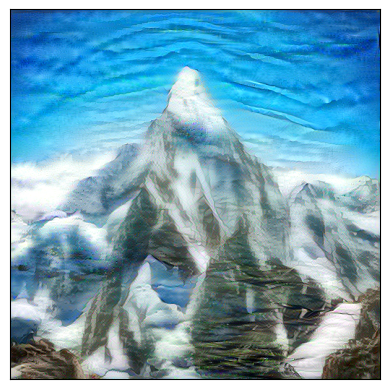

Iteration 400: Loss: 6521732.0


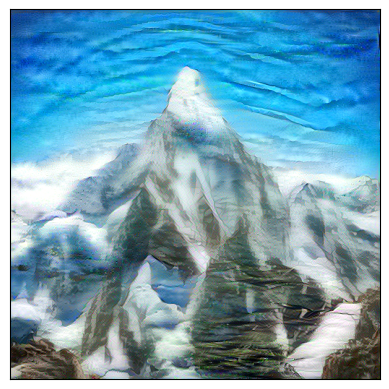

Iteration 500: Loss: 8059426.0


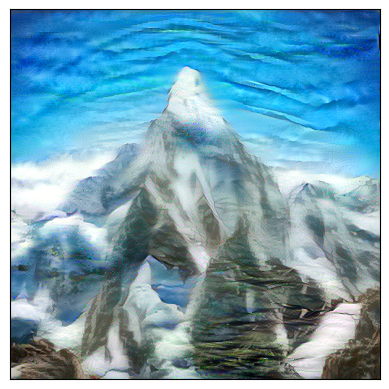

Iteration 600: Loss: 5858322.0


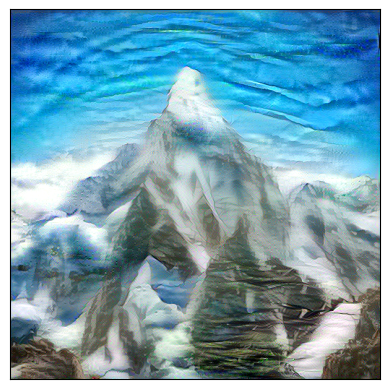

Iteration 700: Loss: 5146164.5


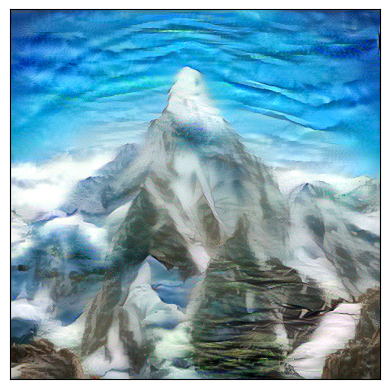

Iteration 800: Loss: 5040782.0


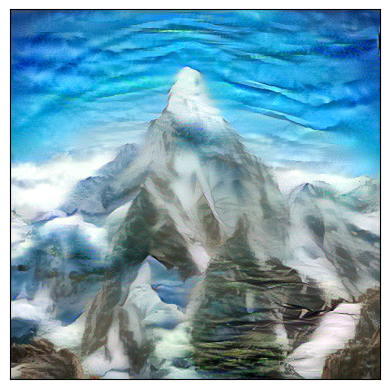

Iteration 900: Loss: 6713130.5


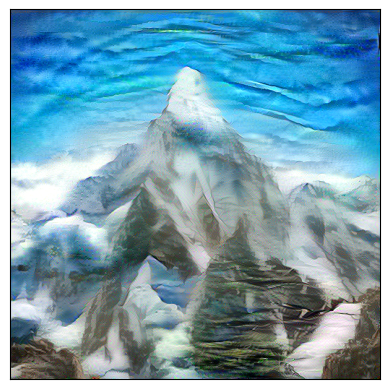

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

# Set global policy to use float32
tf.keras.mixed_precision.set_global_policy('float32')

# Function to load and process image
def load_and_process_image(image_url, target_size=(512, 512)):  # Increased resolution
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).resize(target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return tf.convert_to_tensor(img, dtype=tf.float32)  # Ensure the image tensor is float32

# Deprocess the image
def deprocess(x):
    x = x.reshape((512, 512, 3))  # Adjusted for larger image
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Display image
def display_image(image):
    img = deprocess(image)
    plt.grid(False)
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])

# Content cost
def content_cost(content_output, generated_output):
    return tf.reduce_mean(tf.square(content_output - generated_output))

# Style cost
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.cast(tf.shape(a)[0], tf.float32)  # Ensure n is a float tensor
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / n  # No need for tf.cast here

def style_cost(style_output, generated_output):
    S = gram_matrix(style_output)
    G = gram_matrix(generated_output)
    return tf.reduce_mean(tf.square(S - G))

# Load pre-trained VGG19
def load_vgg_model():
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    return vgg

# Fetch outputs for selected layers
def get_model_outputs(model, layers):
    outputs = [model.get_layer(name).output for name in layers]
    return tf.keras.Model([model.input], outputs)

# Training loop
def style_transfer(content_url, style_url, iterations=1000, content_weight=1e4, style_weight=1e-2):  # Increased iterations
    content_image = load_and_process_image(content_url)
    style_image = load_and_process_image(style_url)
    generated_image = tf.Variable(content_image, dtype=tf.float32)  # Keep this as float32

    vgg = load_vgg_model()

    content_layer = ['block5_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    content_model = get_model_outputs(vgg, content_layer)
    style_model = get_model_outputs(vgg, style_layers)

    content_features = content_model(content_image)
    style_features = style_model(style_image)

    optimizer = tf.optimizers.Adam(learning_rate=5.0)
    for i in range(iterations):
        with tf.GradientTape() as tape:
            generated_content_features = content_model(generated_image)
            generated_style_features = style_model(generated_image)

            # Ensure the features are float32 during loss computation
            J_content = content_cost(tf.cast(content_features[0], tf.float32), generated_content_features[0])
            J_style = sum([style_cost(tf.cast(style_feat, tf.float32), tf.cast(gen_feat, tf.float32))
                           for style_feat, gen_feat in zip(style_features, generated_style_features)])

            total_loss = content_weight * J_content + style_weight * J_style

        gradients = tape.gradient(total_loss, generated_image)
        optimizer.apply_gradients([(gradients, generated_image)])

        if i % 100 == 0:
            print(f"Iteration {i}: Loss: {total_loss.numpy()}")
            display_image(generated_image.numpy())
            plt.show()  # Display after every 100 iterations

    return generated_image

# Save the VGG model used in style transfer as an h5 file
vgg = load_vgg_model()
vgg.save('vgg_model.h5')  # Save feature extraction model

# Example usage
content_image_url = 'https://cdn.mos.cms.futurecdn.net/ntFmJUZ8tw3ULD3tkBaAtf.jpg'
style_image_url = 'https://i.etsystatic.com/25338275/r/il/9b61ed/4762707601/il_570xN.4762707601_dkfd.jpg'

output_image = style_transfer(content_image_url, style_image_url)

# Save the final output image
output_img = deprocess(output_image.numpy()[0])
Image.fromarray(output_img).save('styled_image.png')

plt.imshow(output_img)
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
import numpy as np

# Function to preprocess and load image
def preprocess_image(image):
    img = tf.image.resize(image, (512, 512))
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

# Gram matrix calculation for style
def gram_matrix(tensor):
    shape = tf.shape(tensor)
    reshaped_tensor = tf.reshape(tensor, [shape[1] * shape[2], shape[3]])
    gram = tf.matmul(reshaped_tensor, reshaped_tensor, transpose_a=True)
    return gram / tf.cast(shape[1] * shape[2] * shape[3], tf.float32)

# Define the NST model
def create_nst_model():
    # Load pre-trained VGG19
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    # Define content and style layer names
    content_layers = ['block5_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

    # Extract outputs for selected layers
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    style_outputs = [vgg.get_layer(name).output for name in style_layers]

    # Model to extract style and content features
    model_outputs = content_outputs + style_outputs
    model = Model(inputs=vgg.input, outputs=model_outputs)

    return model

# Function to compute style and content loss
def compute_loss(model, content_image, style_image, generated_image, content_weight, style_weight):
    # Get feature representations
    outputs = model(tf.concat([content_image, style_image, generated_image], axis=0))
    content_features = outputs[:len(content_layers)]
    style_features = outputs[len(content_layers):]

    # Compute content loss
    content_loss = tf.add_n([tf.reduce_mean((content_features[i] - generated_image) ** 2) for i in range(len(content_features))])

    # Compute style loss
    style_loss = tf.add_n([tf.reduce_mean((gram_matrix(style_features[i]) - gram_matrix(generated_image)) ** 2) for i in range(len(style_features))])

    total_loss = content_weight * content_loss + style_weight * style_loss
    return total_loss

# Define the NST model for saving
class NSTModel(tf.keras.Model):
    def __init__(self, content_weight, style_weight, **kwargs):
        super(NSTModel, self).__init__(**kwargs)
        self.nst_model = create_nst_model()
        self.content_weight = content_weight
        self.style_weight = style_weight

    def call(self, inputs):
        content_image, style_image = inputs
        generated_image = tf.Variable(content_image)

        # Optimize generated image to minimize loss
        optimizer = tf.optimizers.Adam(learning_rate=5.0)
        for i in range(1000):  # Reduced for faster computation in frontend
            with tf.GradientTape() as tape:
                loss = compute_loss(self.nst_model, content_image, style_image, generated_image, self.content_weight, self.style_weight)
            gradients = tape.gradient(loss, generated_image)
            optimizer.apply_gradients([(gradients, generated_image)])

        return generated_image

# Instantiate and save the NST model
nst_model = NSTModel(content_weight=1e4, style_weight=1e-2)
nst_model.compile()

# Save the model as .h5 file
nst_model.save('nst_model.h5')


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
